## Ομάδα #75 
### Νικόλαος Μανιάτης - Φίλιππος Μαυρεπής

##### Datasets: S12,	B04,	119

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D

**Dataset Abstract**
NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.

**Attribute Information:**

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

In [2]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
df.isna().sum()

freq         0
angle        0
length       0
velocity     0
thickness    0
pressure     0
dtype: int64

In [4]:
df.corr()

,freq,angle,length,velocity,thickness,pressure
freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
pressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [5]:
df.columns

Index(['freq', 'angle', 'length', 'velocity', 'thickness', 'pressure'], dtype='object')

### Variance Inflation Factor

In [6]:
# VIF dataframe 
vif_data = df.copy()
vif_data = vif_data.drop(['pressure'],axis=1)
# calculating VIF for each feature 
x = [variance_inflation_factor(vif_data.values, i) 
                          for i in range(len(vif_data.columns))] 
  
x

[1.942626754570521,
 6.557489390964023,
 3.2544472087129463,
 7.148723394340731,
 4.299617241817294]

### Train-Test-Split our Dataset

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.copy()
X = X.drop(['pressure'],axis=1)
y = df[['pressure']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)
print('X train shape:',X_train.shape)
print('X test shape:',X_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

X train shape: (1052, 5)
X test shape: (451, 5)
y train shape: (1052, 1)
y test shape: (451, 1)


## Ordinary Least Squares

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
reg.score(X_test, y_test)

0.48701529018157896

#### Recursive Feature Elimination

In [13]:
from sklearn.feature_selection import RFE

In [14]:
selector = RFE(reg, n_features_to_select=4, step=1,verbose=2)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

Fitting estimator with 5 features.
[False  True  True  True  True]
[2 1 1 1 1]


## Polynomial Regression

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [16]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

array([[1.00000000e+00, 8.00000000e+02, 0.00000000e+00, ...,
        5.08369000e+03, 1.89898281e-01, 7.09353976e-06],
       [1.00000000e+00, 1.00000000e+03, 0.00000000e+00, ...,
        5.08369000e+03, 1.89898281e-01, 7.09353976e-06],
       [1.00000000e+00, 1.25000000e+03, 0.00000000e+00, ...,
        5.08369000e+03, 1.89898281e-01, 7.09353976e-06],
       ...,
       [1.00000000e+00, 4.00000000e+03, 1.56000000e+01, ...,
        1.56816000e+03, 2.09280852e+00, 2.79298509e-03],
       [1.00000000e+00, 5.00000000e+03, 1.56000000e+01, ...,
        1.56816000e+03, 2.09280852e+00, 2.79298509e-03],
       [1.00000000e+00, 6.30000000e+03, 1.56000000e+01, ...,
        1.56816000e+03, 2.09280852e+00, 2.79298509e-03]])

In [17]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
...                   ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train,y_train)
model.named_steps['linear'].coef_
model.score(X_test, y_test)

0.6223336446282257

In [18]:
for i in range(1,4):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)),
    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    model = model.fit(X_train,y_train)
    model.named_steps['linear'].coef_
    print('degree of polynomial = {} and score is {}'.format(i,model.score(X_test, y_test)))

degree of polynomial = 1 and score is 0.48701529018065426
degree of polynomial = 2 and score is 0.6223336446282257
degree of polynomial = 3 and score is 0.7209720262016102


### Pycaret

In [19]:
from pycaret.regression import *

exp_reg102 = setup(data = df, target = 'pressure', session_id=123,
                  normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  log_experim
                   ent = True, experiment_name = 'NASA',polynomial_features=True,use_gpu=True,
                  polynomial_degree=3)




,Description,Value
0,session_id,123
1,Target,pressure
2,Original Data,"(1503, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1052, 7)"


In [20]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,1.1890,3.0512,1.7227,0.9330,0.0137,0.0096,0.7600
et,Extra Trees Regressor,1.2093,3.1266,1.7402,0.9314,0.0139,0.0098,0.4490
lightgbm,Light Gradient Boosting Machine,1.3872,3.9240,1.9607,0.9145,0.0156,0.0112,0.1000
rf,Random Forest Regressor,1.4532,4.1399,2.0081,0.9102,0.0159,0.0117,0.3780
gbr,Gradient Boosting Regressor,2.1083,7.7385,2.7691,0.8277,0.0218,0.0169,0.0770
dt,Decision Tree Regressor,2.0402,8.3121,2.8661,0.8150,0.0228,0.0164,0.0100
knn,K Neighbors Regressor,2.3466,10.5500,3.2191,0.7665,0.0257,0.0190,0.3070
ada,AdaBoost Regressor,3.3517,17.3746,4.1459,0.6187,0.0334,0.0273,0.0780
lr,Linear Regression,3.4970,21.8829,4.6535,0.5153,0.0369,0.0281,0.0120
ridge,Ridge Regression,3.4980,21.8841,4.6537,0.5153,0.0369,0.0281,0.0100


In [21]:
dt = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.1506,2.5712,1.6035,0.9481,0.0127,0.0092
1,1.2169,3.1186,1.7660,0.9314,0.0144,0.0100
2,1.4044,3.9301,1.9825,0.9274,0.0162,0.0115
3,1.1593,2.5727,1.6040,0.9292,0.0128,0.0093
4,1.0393,2.1874,1.4790,0.9515,0.0117,0.0084
5,1.0126,2.0227,1.4222,0.9438,0.0115,0.0082
6,1.4227,6.0967,2.4692,0.8669,0.0193,0.0114
7,1.0289,1.9852,1.4090,0.9413,0.0113,0.0083
8,1.4021,4.0095,2.0024,0.9183,0.0155,0.0112
9,1.2559,2.7719,1.6649,0.9562,0.0133,0.0102


In [22]:
bagged_dt = ensemble_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.2848,2.9640,1.7216,0.9401,0.0138,0.0104
1,1.4439,3.9961,1.9990,0.9121,0.0162,0.0118
2,1.6028,4.6672,2.1604,0.9137,0.0175,0.0131
3,1.3251,3.3204,1.8222,0.9087,0.0145,0.0106
4,1.3018,3.0298,1.7406,0.9329,0.0138,0.0105
5,1.2319,3.0413,1.7439,0.9155,0.0139,0.0099
6,1.6579,7.5620,2.7499,0.8349,0.0216,0.0133
7,1.2048,2.6626,1.6318,0.9213,0.0131,0.0097
8,1.4899,4.8324,2.1983,0.9015,0.0169,0.0118
9,1.5110,3.7838,1.9452,0.9403,0.0157,0.0123


In [23]:
stacker = stack_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0098,2.0492,1.4315,0.9586,0.0113,0.0081
1,1.0711,3.2926,1.8146,0.9276,0.0147,0.0088
2,1.2510,3.1951,1.7875,0.9410,0.0145,0.0102
3,1.0414,2.0489,1.4314,0.9436,0.0114,0.0083
4,1.1167,2.4289,1.5585,0.9462,0.0124,0.0090
5,0.9496,1.5572,1.2479,0.9567,0.0101,0.0076
6,1.3207,5.1653,2.2727,0.8873,0.0177,0.0106
7,0.9169,1.6628,1.2895,0.9508,0.0104,0.0074
8,1.2469,3.3501,1.8303,0.9317,0.0142,0.0099
9,1.0771,2.2834,1.5111,0.9640,0.0119,0.0087


In [24]:
xgboost = create_model('lightgbm')
stacker2 = stack_models(top3, meta_model = xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.4058,3.6041,1.8984,0.9272,0.0151,0.0113
1,1.2870,3.9689,1.9922,0.9127,0.0160,0.0105
2,1.6121,4.7895,2.1885,0.9115,0.0176,0.0131
3,1.2783,2.9126,1.7066,0.9199,0.0135,0.0102
4,1.4416,4.1593,2.0394,0.9079,0.0163,0.0117
5,1.1838,2.2528,1.5009,0.9374,0.0118,0.0094
6,1.6457,6.4614,2.5419,0.8590,0.0200,0.0132
7,1.1930,2.7053,1.6448,0.9200,0.0132,0.0096
8,1.2694,4.0107,2.0027,0.9183,0.0155,0.0101
9,1.5555,4.3754,2.0917,0.9309,0.0167,0.0125


IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:34:23
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Stacking Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


KeyboardInterrupt: 

In [ ]:
tuned_et = tune_model(dt)

In [25]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
X = df.copy()
X = X.drop(['pressure'],axis=1)
y = df[['pressure']]

In [4]:
from sklearn import preprocessing
scaler_x = preprocessing.MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = preprocessing.MinMaxScaler()
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))
y_scaled = y_scaled.reshape(-1)
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y_scaled, random_state=1)
# val_y = scaler_y.inverse_transform(np.array(val_y).reshape(-1,1))

In [82]:
models = []
models.append(('LR', LinearRegression()))
models.append(('RD', Ridge()))
models.append(('LAS', Lasso()))
models.append(('DT', DecisionTreeRegressor(random_state=75)))
models.append(('MLP', MLPRegressor(random_state=75)))
models.append(('SVR',SVR()))
models.append(('ET',ExtraTreesRegressor(random_state=75)))
models.append(('XGB', XGBRegressor(random_state=75)))

In [84]:
def compare_models(a,b,c,d,models):
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = KFold(n_splits=10,shuffle=True,random_state = 75)
        accuracy_results = cross_val_score(model, a,b, cv=kfold)
        resultsAccuracy.append(accuracy_results.mean())
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
        
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: R^2')
    ax = fig.add_subplot(111)
    plt.bar(names,resultsAccuracy,color=['firebrick','firebrick','firebrick','seagreen','seagreen','seagreen',
                                        'purple','purple'])

   
    legend_elements = [Line2D([0], [0], color='firebrick', lw=4, label='Linear Models'),
                   Line2D([0], [0], color='seagreen', lw=4,label='Misc Models'),
                   Line2D([0], [0], color='purple',lw=4, label='Ensemble Models')]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper left')

    ax.set_ylabel('Cross-Validation: R^2')
    plt.show()
    return


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.521027 (0.112379)
RD: 0.520691 (0.109472)
LAS: -0.010131 (0.011227)
DT: 0.826076 (0.044887)
MLP: 0.629382 (0.107893)
SVR: 0.743603 (0.071889)
ET: 0.940562 (0.012604)
XGB: 0.939339 (0.012916)


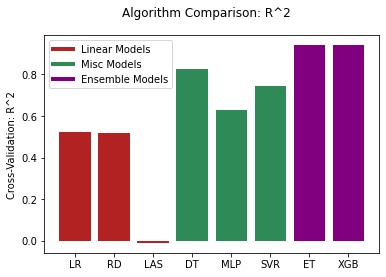

In [85]:
compare_models(train_X, train_y, test_X, test_y, models)

About LASSO:
It's not impossible to get an R^2 value less than 0.
R^2 is a metric used to measure the performance of a regressor. The optimal score of R^2 metric is 1. If any regressor predicts a constant value, you should expect an R^2 score of 0 for that regressor. **But unexpectedly, you can get worse performance than that.**

## Optimization 

In [41]:
models_opt = []

#### Linear Regression: Has to hyperparameters to optimize.

In [42]:
LR = LinearRegression()
models_opt.append(('LD*',LR))

#### Ridge Regression

In [43]:
%%time
Ridge_ = GridSearchCV(Ridge(), param_grid = {'alpha':[i for i in np.arange(0,1,0.01)],\
                                                'solver':('svd', 'cholesky', 'lsqr')},cv=10)
Ridge_.fit(train_X,train_y)

Wall time: 4.04 s


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                   0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                                   0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,
                                   0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27,
                                   0.28, 0.29, ...],
                         'solver': ('svd', 'cholesky', 'lsqr')})

In [44]:
Ridge_opt = Ridge_.best_estimator_
models_opt.append(('RD*',Ridge_opt))

#### Lasso Regression

In [45]:
%%time
Lasso_ = GridSearchCV(Lasso(), param_grid = {'alpha':[0.0001, 0.0002,0.001,0.01,0.1,0.2,0.5,0.8,1],\
                                            'max_iter':[k for k in np.arange(1000,10000,500)],
                                            'tol':[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]},cv=10)
Lasso_.fit(train_X,train_y)

Wall time: 11.7 s


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.001, 0.01, 0.1, 0.2, 0.5,
                                   0.8, 1],
                         'max_iter': [1000, 1500, 2000, 2500, 3000, 3500, 4000,
                                      4500, 5000, 5500, 6000, 6500, 7000, 7500,
                                      8000, 8500, 9000, 9500],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                 1e-08]})

In [46]:
Lasso_opt = Lasso_.best_estimator_
models_opt.append(('LAS*',Lasso_opt))

Παρατηρούμε ότι στις περιπτώσεις Ridge&Lasso Regression το γεγονός ότι $\alpha\rightarrow 0$, σημαίνει ότι το πρόβλημά μας τείνει σε αυτό της απλής γραμμικής παλινδρόμησης επομένως παίρνουμε τους ίδιους συντελεστές με αυτό, γιαυτό και οι 2 τιμές του $R^2$ συγκλίνουν προς αυτό της γραμμικής παλινδρόμησης.

#### Decision Trees Regressor

In [49]:
%%time
DT_ = GridSearchCV(DecisionTreeRegressor(), param_grid = {'criterion': ['mse', 'mae'],
                                                          'max_depth': range(1,15),
                                                         "min_samples_split":range(2,10),
                                                         "min_samples_leaf":range(1,5)}
                                                          ,n_jobs = -1,cv=10)
DT_.fit(train_X, train_y)

Wall time: 15.4 s


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)})

In [50]:
DT_opt = DT_.best_estimator_
models_opt.append(('DT*',DT_opt))

In [52]:
%%time
MLP_ = GridSearchCV(MLPRegressor(warm_start=True,random_state=75), param_grid={'activation' : ['tanh','relu'],
                                                'solver':['sgd','adam'],
                                                'alpha':[1e-5,1e-4,1e-3],
                                                'learning_rate':['constant','adaptive'],
                                                'max_iter':[100,200,1000],
                                                'learning_rate_init':[0.0001,0.001,0.003,0.005,0.01]},
                                                 n_jobs = -1,cv=10)
MLP_.fit(train_X,train_y)

Wall time: 2min 22s


GridSearchCV(cv=10, estimator=MLPRegressor(random_state=75, warm_start=True),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [1e-05, 0.0001, 0.001],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.0001, 0.001, 0.003, 0.005,
                                                0.01],
                         'max_iter': [100, 200, 1000],
                         'solver': ['sgd', 'adam']})

**Multi Layer Perceptron Regressor (no-hidden layers)**

In [53]:
MLP_opt = MLP_.best_estimator_
models_opt.append(('MLP*',MLP_opt))

In [54]:
MLP_opt

MLPRegressor(learning_rate_init=0.01, random_state=75, warm_start=True)

**Multi Layer Perceptron (with hidden layers)**

In [56]:
%%time
MLP_2 = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam',alpha=0.0001,learning_rate = 'constant',
                                  warm_start=True,random_state=75), 
                                 param_grid={'max_iter':[100,200,1000],'learning_rate_init':[0.0001,0.001,0.005],
                                'hidden_layer_sizes':[(256, 256, 256),(512,256,128),(64,32,8)]},n_jobs = -1)
MLP_2.fit(train_X,train_y)

Wall time: 1min 53s


GridSearchCV(estimator=MLPRegressor(random_state=75, warm_start=True),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(256, 256, 256),
                                                (512, 256, 128), (64, 32, 8)],
                         'learning_rate_init': [0.0001, 0.001, 0.005],
                         'max_iter': [100, 200, 1000]})

In [57]:
MLP_opt2 = MLP_2.best_estimator_

In [58]:
models_opt.append(('MLP2*',MLP_opt2))


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LD*: 0.521027 (0.112379)
RD*: 0.521074 (0.111340)
LAS*: 0.521033 (0.111738)
DT*: 0.829051 (0.038359)
MLP*: 0.645071 (0.113880)
MLP2*: 0.851448 (0.048052)


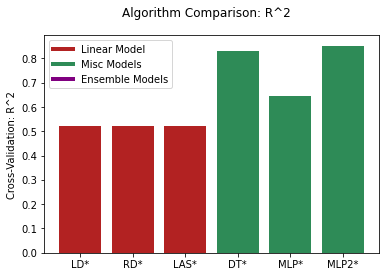

In [59]:
compare_models(train_X, train_y, test_X, test_y, models_opt)

In [60]:
MLP_opt2

MLPRegressor(hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.005,
             max_iter=100, random_state=75, warm_start=True)

Υπενθύμιση μην το ξεχάσουμε: Το hidden_layer_size = (256, 256, 256) έβγαλε το καλύτερο score, ~86.7 \%.

**Extra Trees Regressor**

In [61]:
%%time
ET_ = GridSearchCV(ExtraTreesRegressor(random_state=75), param_grid = {'criterion': ['mse', 'mae'],
                                                          'max_depth': range(1,15),
                                                         "min_samples_split":range(2,10),
                                                         "min_samples_leaf":range(1,5)},
                                                           n_jobs = -1,cv=10)
ET_.fit(train_X, train_y)

Wall time: 13min 9s


GridSearchCV(cv=10, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)})

In [87]:
ET_opt = ET_.best_estimator_
models_opt.append(('ET*',ET_opt))

In [88]:
models_opt

[('LD*', LinearRegression()),
 ('RD*', Ridge(alpha=0.35000000000000003, solver='svd')),
 ('LAS*', Lasso(alpha=0.0001, tol=1e-08)),
 ('DT*',
  DecisionTreeRegressor(criterion='mae', max_depth=14, min_samples_split=3)),
 ('MLP*',
  MLPRegressor(learning_rate_init=0.01, random_state=75, warm_start=True)),
 ('MLP2*',
  MLPRegressor(hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.005,
               max_iter=100, random_state=75, warm_start=True)),
 ('ET*', ExtraTreesRegressor(max_depth=14))]


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LD*: 0.521027 (0.112379)
RD*: 0.521074 (0.111340)
LAS*: 0.521033 (0.111738)
DT*: 0.827986 (0.036860)
MLP*: 0.645071 (0.113880)
MLP2*: 0.851448 (0.048052)
ET*: 0.939103 (0.013158)


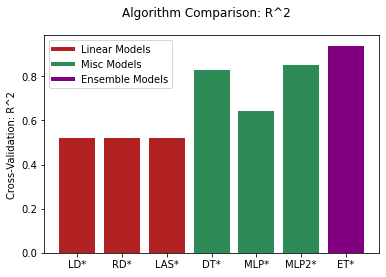

In [89]:
compare_models(train_X, train_y, test_X, test_y, models_opt)

**XG Boost Regressor**

In [106]:
%%time
XGB_ = GridSearchCV(XGBRegressor(random_state=75,n_jobs=-1),
                                                            param_grid  = {'min_child_weight':[1,5], 
                                                            'gamma':[i/10.0 for i in range(3,6)],  
                                                            'subsample':[i/10.0 for i in range(6,11)],
                                                            'colsample_bytree':[i/10.0 for i in range(0,5)], 
                                                            'max_depth': [5,6,7],
                                                             'n_estimators':[100,500,1000]},
                                                            n_jobs=-1,cv=10)
XGB_.fit(train_X, train_y)

Wall time: 33min 15s


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    num_parallel_tree=None, random_state=75,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramete

In [107]:
XGB_opt = XGB_.best_estimator_
del models_opt[-1]
models_opt.append(('XGB*',XGB_opt))


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LD*: 0.521027 (0.112379)
RD*: 0.521074 (0.111340)
LAS*: 0.521033 (0.111738)
DT*: 0.822833 (0.039514)
MLP*: 0.645071 (0.113880)
MLP2*: 0.851448 (0.048052)
ET*: 0.938214 (0.014201)
XGB*: 0.764351 (0.057012)


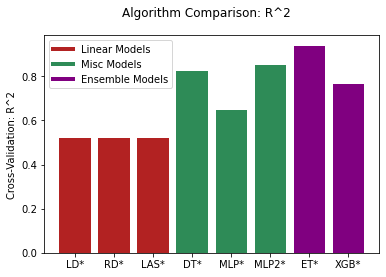

In [108]:
compare_models(train_X, train_y, test_X, test_y, models_opt)

In [105]:
XGB_.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)